In [1]:
import binning
import cmasher as cmr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
import srd_redshift_distributions
from tabulate import tabulate

# Perform binning

In [2]:
def get_bins_for_year_and_sample(redshift_range, forecast_year, galaxy_sample):
    """
    Generate bins for a specific LSST forecast year and galaxy sample type.

    Parameters:
    - redshift_range (np.ndarray): Array containing the range of redshift values.
    - forecast_year (str): The desired year for which data is to be fetched. Can be "1", "10", etc.
    - galaxy_sample (str): Type of galaxy sample. Can be "source_sample" or "lens_sample".

    Returns:
    - np.ndarray: Binned data for the given forecast year and galaxy sample.

    Raises:
    - ValueError: If the provided galaxy_sample is neither "source_sample" nor "lens_sample".
                  If the forecast_year is neither "1" nor "10".
    """
    
    # Check if forecast_year is valid
    if forecast_year not in ["1", "10"]:
        raise ValueError(f"Invalid forecast_year: {forecast_year}. Expected '1' or '10'.")

    srd = srd_redshift_distributions.SRD(galaxy_sample=galaxy_sample, 
                                         forecast_year=forecast_year)

    dndz = srd.get_redshift_distribution(redshift_range,
                                         normalised=True,
                                         save_file=False)

    if galaxy_sample == "source_sample":
        return binning.Binning(redshift_range, dndz, forecast_year).source_bins(normalised=True, save_file=True)
    elif galaxy_sample == "lens_sample":
        return binning.Binning(redshift_range, dndz, forecast_year).lens_bins(normalised=True, save_file=True)
    else:
        raise ValueError(f"Unknown galaxy_sample: {galaxy_sample}")

redshift_range = np.linspace(0.01, 4., 400)

# Creating a nested dictionary with galaxy sample type as the top-level key and year as the secondary key
fisk_bins = {
    "sources": {},
    "lenses": {}
}

for year in ["1", "10"]:
    fisk_bins["sources"][year] = get_bins_for_year_and_sample(redshift_range, year, "source_sample")
    fisk_bins["lenses"][year] = get_bins_for_year_and_sample(redshift_range, year, "lens_sample")


# Validate source bins

Load the bins from C.D. Leonard. These source bins are used as a valdiation check (a benchmark). 

Note: only source bins for Y1 and Y10 available from C.D. Leonard but the binning procedure for lenses is the same, only with different parameters.

In [3]:
# Read benchmark data
benchmark_files = {
    "1": "benchmarks/dNdz_srcs_LSSTSRD_Y1_zb0_sigz0.05.dat",
    "10": "benchmarks/dNdz_srcs_LSSTSRD_Y10.dat"
}

dl_bins = {
    "sources": {}
}

redshift_range_dl_y1 = None
redshift_range_dl_y10 = None

for year, file_path in benchmark_files.items():
    data = pd.read_csv(file_path, delimiter=" ", header=None)
    
    # Extract the redshift column based on the year and store it
    if year == "1":
        redshift_range_dl_y1 = np.array(data[0])
    elif year == "10":
        redshift_range_dl_y10 = np.array(data[0])

    # Normalize each bin separately
    data_normalized = data.copy()
    for column in data.columns[1:]:
        data_normalized[column] = data[column] / np.trapz(data[column], data[0])
    
    # Store the normalized data for each year
    dl_bins["sources"][year] = data_normalized


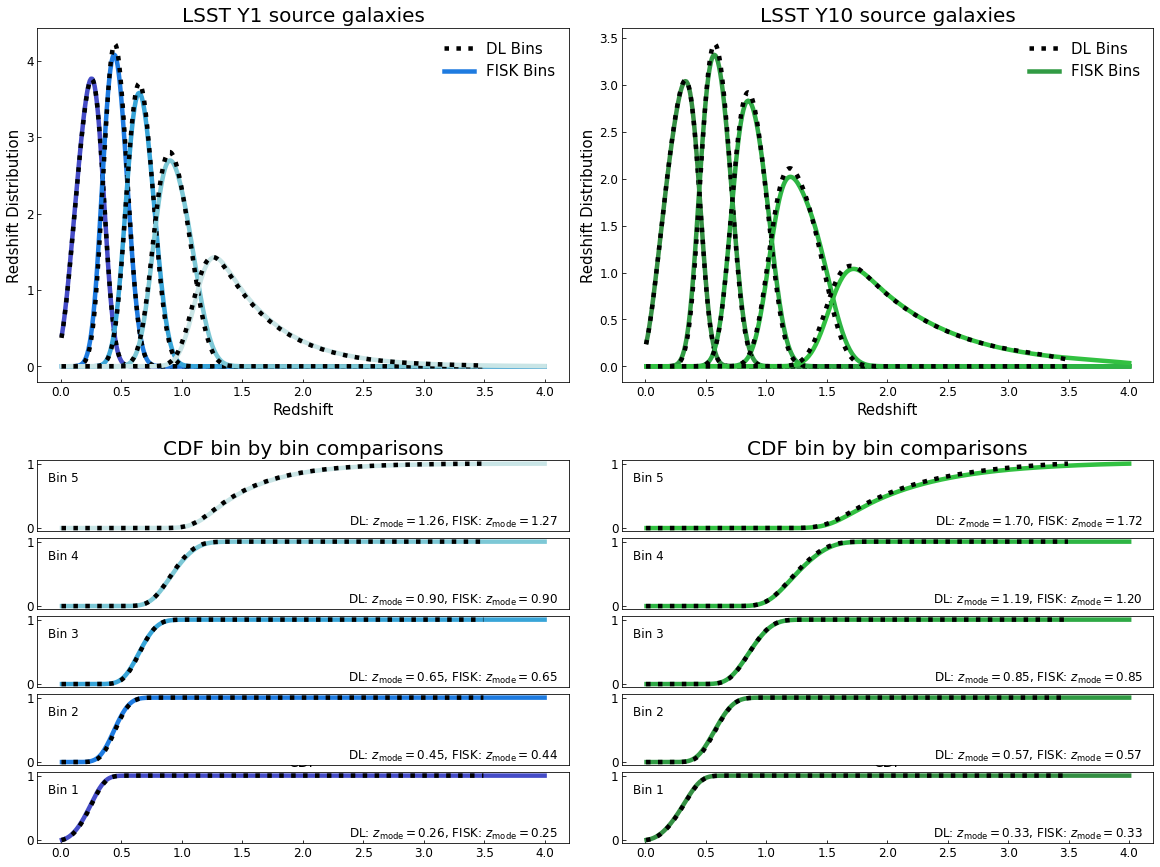

In [4]:
def get_z_peak(nz, redshift):
    """
    Computes zmax and peak value for the given distribution 'nz'.
    """
    max_idx = np.argmax(nz)
    return redshift[max_idx], nz[max_idx]

def plot_stats_on_axis(axis, x1, y1, x2, y2, bin_idx, z_peak_dl=None, z_peak_fisk=None, inset_color="k"):
    """
    This function plots the data on a specified axis.
    """
    axis.axis('off')
    
    ax_inset = axis.inset_axes([0, 0.22 * bin_idx, 1, 0.20])
    ax_inset.tick_params(direction='in', labelsize=12)
    
    if z_peak_dl is not None and z_peak_fisk is not None:
        stats_info = (f"Bin {bin_idx+1} | DL: $z_\\mathrm{{mode}}={z_peak_dl:.2f}$, "
                      f"FISK: $z_\\mathrm{{mode}}={z_peak_fisk:.2f}$")
    else:
        stats_info = f"Bin {bin_idx+1}"

    if y2 is not None:
        ax_inset.plot(x2, y2, color=inset_color)
        ks_stat, p_value = ks_2samp(y1, y2)
        bin_info = f"Bin {bin_idx+1}"
        ax_inset.text(0.02, 0.7, bin_info, transform=ax_inset.transAxes, fontsize=12)
        stats_info = f"DL: $z_\\mathrm{{mode}}={z_peak_dl:.2f}$, FISK: $z_\\mathrm{{mode}}={z_peak_fisk:.2f}$"
        ax_inset.text(0.98, 0.08, stats_info, transform=ax_inset.transAxes, fontsize=12, ha='right')
    
    ax_inset.plot(x1, y1, color="k", ls=":")
    
    if bin_idx != 0:
        ax_inset.set_xticks([])
    else:
        ax_inset.set_title("CDF", fontsize=14)

fig, ax = plt.subplots(2, 2, figsize=(20, 15))
ax = ax.T  # Transpose the axes
plt.rcParams['lines.linewidth'] = 4.5
y1_colors = cmr.take_cmap_colors('cmr.freeze', 5, cmap_range=(0.4, 0.9), return_fmt='hex')
y10_colors = cmr.take_cmap_colors('cmr.nuclear', 10, cmap_range=(0.6, 1), return_fmt='hex')

source_colors = {
    "1": y1_colors,
    "10": y10_colors
}


for sub_ax in ax.ravel():
    sub_ax.tick_params(direction='in', labelsize=12)

# Function to plot data for a given year
def plot_year_data(year, ax_row, color, redshift_range_dl):
    # Loop over bins for dl_bins and fisk_bins
    for idx, (key, value) in enumerate(fisk_bins["sources"][year].items()):
        # Plot for fisk_bins
        #ax_row[0].plot(redshift_range, value, color=color)
        ax_row[0].plot(redshift_range, value, color=source_colors[year][idx])
        
        cdf_fisk = np.cumsum(value) / np.sum(value)
        z_peak_fisk = get_z_peak(value, redshift_range)[0]
        
        # Extracting the data for dl_bins for the current bin
        dl_bin_data = dl_bins["sources"][year][idx+1]  # Increment by 1 since the 0th column is redshift
        
        # Plot for dl_bins
        cdf_dl = np.cumsum(dl_bin_data) / np.sum(dl_bin_data)
        z_peak_dl = get_z_peak(dl_bin_data, redshift_range_dl)[0]
        
        plot_stats_on_axis(ax_row[1], redshift_range_dl, cdf_dl,
                           redshift_range, cdf_fisk, idx, z_peak_dl, z_peak_fisk, inset_color=source_colors[year][idx])

        ax_row[0].plot(redshift_range_dl, dl_bin_data, color="k", ls=":")
        
    # Set labels for the plots
    ax_row[0].set_xlabel("Redshift", fontsize=15)
    ax_row[0].set_ylabel("Redshift Distribution", fontsize=15)
    ax_row[1].set_xlabel("Redshift", fontsize=15)
    ax_row[1].set_ylabel("CDF", fontsize=15)
        
    # Add the legends for DL and FISK Bins (outside the loop so it only gets added once)
    ax_row[0].plot([], [], ls=":", color="k", label=f"DL Bins")
    ax_row[0].plot([], [], color=source_colors[year][1], label=f"FISK Bins")
    ax_row[0].legend(loc='upper right', fontsize=15, frameon=False)

# Plot data for Y1
plot_year_data("1", ax[0], source_colors["1"][1], redshift_range_dl_y1)
ax[0,0].set_title("LSST Y1 source galaxies", fontsize=20)
ax[0,1].set_title("CDF bin by bin comparisons", fontsize=20)

# Plot data for Y10
plot_year_data("10", ax[1], source_colors["10"][1], redshift_range_dl_y10)
ax[1,0].set_title("LSST Y10 source galaxies", fontsize=20)
ax[1,1].set_title("CDF bin by bin comparisons", fontsize=20)

plt.subplots_adjust(hspace=0.3, wspace=0.1) 
plt.show()


## Peak stats

In [5]:
# This function will collect and return the comparison statistics.
def gather_comparison_stats_for_year(year, redshift_range_dl):
    stats_data = []

    # Loop over bins for dl_bins and fisk_bins
    for idx, (key, value) in enumerate(fisk_bins["sources"][year].items()):
        
        cdf_fisk = np.cumsum(value) / np.sum(value)
        z_peak_fisk, nz_max_fisk = get_z_peak(value, redshift_range)
        
        # Extracting the data for dl_bins for the current bin
        dl_bin_data = dl_bins["sources"][year][idx+1]
        
        cdf_dl = np.cumsum(dl_bin_data) / np.sum(dl_bin_data)
        z_peak_dl, nz_max_dl = get_z_peak(dl_bin_data, redshift_range_dl)
        
        stats_data.append([idx+1, z_peak_dl, z_peak_fisk, nz_max_dl, nz_max_fisk])

    return stats_data

# Gather stats for Y1 and Y10
y1_stats = gather_comparison_stats_for_year("1", redshift_range_dl_y1)
y10_stats = gather_comparison_stats_for_year("10", redshift_range_dl_y10)

# Formatting and printing the stats as tables
headers = ["Bin", "z_peak_DL", "z_peak_FISK", "nz_max_DL", "nz_max_FISK"]

print("\nLSST Y1 Source Galaxies Comparison:\n")
print(tabulate(y1_stats, headers=headers, tablefmt='grid'))
print("\nLSST Y10 Source Galaxies Comparison:\n")
print(tabulate(y10_stats, headers=headers, tablefmt='grid'))



LSST Y1 Source Galaxies Comparison:

+-------+-------------+---------------+-------------+---------------+
|   Bin |   z_peak_DL |   z_peak_FISK |   nz_max_DL |   nz_max_FISK |
+=======+=============+===============+=============+===============+
|     1 |    0.255374 |          0.25 |     3.76027 |       3.7653  |
+-------+-------------+---------------+-------------+---------------+
|     2 |    0.445583 |          0.44 |     4.21963 |       4.08104 |
+-------+-------------+---------------+-------------+---------------+
|     3 |    0.648008 |          0.65 |     3.70436 |       3.57971 |
+-------+-------------+---------------+-------------+---------------+
|     4 |    0.899293 |          0.9  |     2.80547 |       2.69424 |
+-------+-------------+---------------+-------------+---------------+
|     5 |    1.25703  |          1.27 |     1.4309  |       1.42585 |
+-------+-------------+---------------+-------------+---------------+

LSST Y10 Source Galaxies Comparison:

+-------+----

## QQ plots

### Interpreting QQ Plots:

1. **On the Straight Line (y=x)**:
   - Points on or near the 45-degree line suggest similar distributions for both datasets.

2. **Deviations from the Line**:
   - Points below the line indicate that values from the first dataset are smaller than the second.
   - Points above show the opposite: values from the first dataset are larger.

3. **Patterns**:
   - An **S-Shaped Curve** hints at discrepancies, possibly in the tails of the distributions.
   - A **bulge in the center** signals differences in the central portions.
   - **Deviations at the ends** suggest differences in the tails.

4. **Wide Point Spread**:
   - Points spread around the line indicate greater variability in one distribution.

5. **Outliers**:
   - Distinct outliers hint at specific value ranges where the distributions notably differ.

*Note*: QQ plots are visual tools to compare distribution shapes. While they highlight differences, they don't specify the causes.


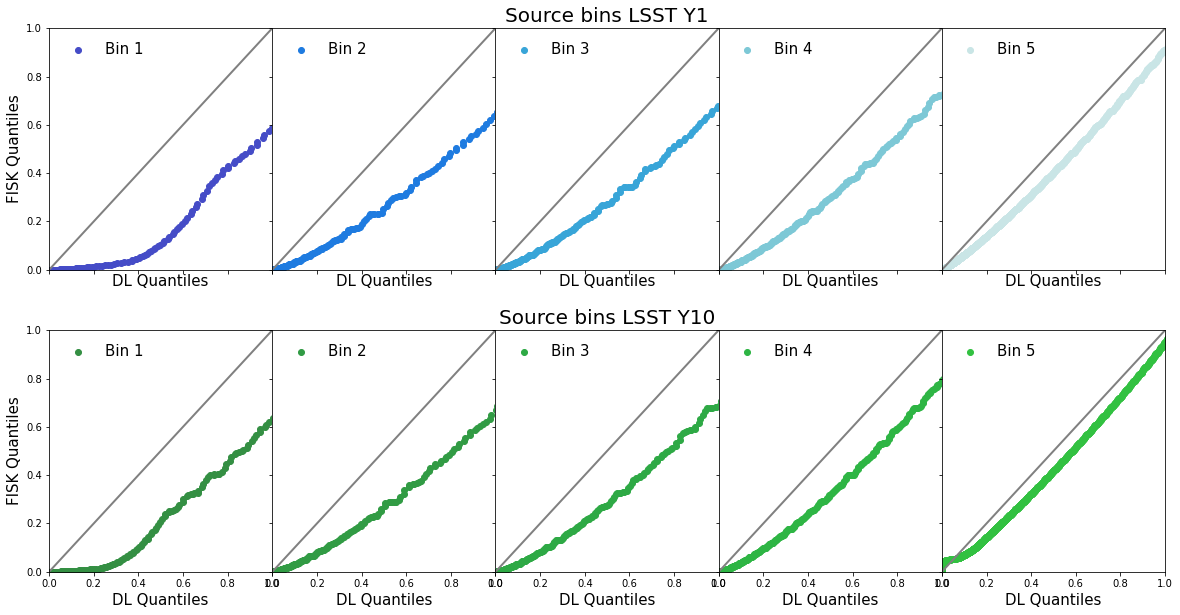

In [6]:
def compute_qq_data(sample1, sample2, num_quantiles=2000):
    """
    Compute QQ plot data for two samples using a fixed number of quantiles.
    """
    quantiles_1 = np.percentile(sample1, np.linspace(0, 100, num_quantiles))
    quantiles_2 = np.percentile(sample2, np.linspace(0, 100, num_quantiles))
    return quantiles_1, quantiles_2

def plot_qq_for_year(year, ax_row, color_map, redshift_range_dl):
    """
    This function plots QQ data for the given year.
    """
    for idx, (key, value) in enumerate(fisk_bins["sources"][year].items()):
        # Extracting the data for the current bin
        dl_bin_data = dl_bins["sources"][year][idx+1]
        
        # Compute QQ data
        quantiles_dl, quantiles_fisk = compute_qq_data(dl_bin_data, value)
        
        # Plot the QQ data
        ax_row[idx].scatter(quantiles_dl, quantiles_fisk, color=color_map[idx], label=f"Bin {idx+1}")
        ax_row[idx].plot([0, 1], [0, 1], ls="-", c="gray", lw=2)  # Diagonal line for reference
        ax_row[idx].set_xlim(0, 1)
        ax_row[idx].set_ylim(0, 1)
        ax_row[idx].set_xlabel("DL Quantiles", fontsize=15)
        
        if idx == 0:
            ax_row[idx].set_ylabel("FISK Quantiles", fontsize=15)
        else:
            ax_row[idx].set_ylabel("")
        
        ax_row[idx].legend(loc="upper left", frameon=False, fontsize=15)

# Create subplots with shared x and y axes settings
fig, ax = plt.subplots(2, len(fisk_bins["sources"]["1"]), figsize=(20, 10), sharex=True, sharey='row')
plt.subplots_adjust(hspace=0.25, wspace=0.)

# Set general titles for the rows
ax[0][2].set_title("Source bins LSST Y1", fontsize=20)
ax[1][2].set_title("Source bins LSST Y10", fontsize=20)

# For Y1
plot_qq_for_year("1", ax[0], source_colors["1"], redshift_range_dl_y1)

# For Y10
plot_qq_for_year("10", ax[1], source_colors["10"], redshift_range_dl_y10)

plt.show()


**Upon inspection, the differences are most likely in the tails. Considering the peaks match and the CDFs match, we ca conclude that the FISK binning procedure agrees with DL benchmark to high precision.**

# Lens bins

Procedure for lenses is described in the SRD and implelented as such. Check binning.py.

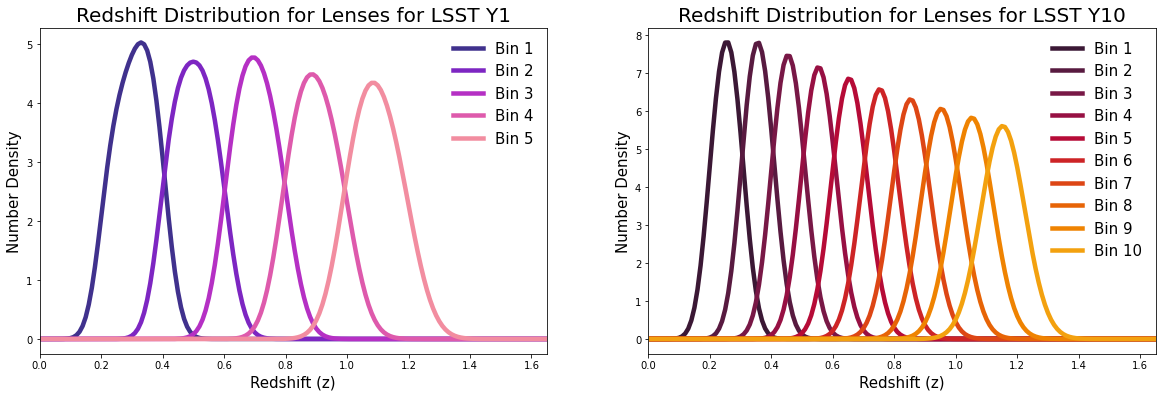

In [7]:
oranges = cmr.take_cmap_colors('cmr.bubblegum', 5, cmap_range=(0.2, 0.85), return_fmt='hex')
pinks = cmr.take_cmap_colors('cmr.ember', 10, cmap_range=(0.2, 0.85), return_fmt='hex')

fig, axes = plt.subplots(1, 2, figsize=(20,6))

lens_colors = {
    "1": oranges,   # bright orange shades for Y1
    "10": pinks   # bright pink shades for Y10
}

for idx, year in enumerate(["1", "10"]):
    ax = axes[idx]
    for bin_idx, (key, data) in enumerate(fisk_bins["lenses"][year].items()):
        ax.plot(redshift_range, data, label=f"Bin {key+1}", color=lens_colors[year][bin_idx])
        
    ax.set_xlim(0, 1.65)
    ax.set_title(f"Redshift Distribution for Lenses for LSST Y{year}", fontsize=20)
    ax.set_xlabel("Redshift (z)", fontsize=15)
    ax.set_ylabel("Number Density", fontsize=15)
    ax.legend(frameon=False, fontsize=15)

plt.show()
